# Libraries

In [1]:
#! pip install pandas numpy matplotlib seaborn rasterio tqdm pyproj shapely scikit-learn tensorflow==2.10.0
#! conda install -c conda-forge libgdal -y
#! conda install -c conda-forge gdal -y

#### Data exploration and visualization

In [2]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#### Raster manipulation

In [3]:
import rasterio as rio
from rasterio import warp, mask, features
from rasterio.windows import Window
from rasterio.plot import show, reshape_as_image, adjust_band, reshape_as_raster
from osgeo import gdal, ogr, osr

#### Manipulate polygons.

In [4]:
from tqdm import tqdm
from shapely.geometry import Polygon
from pyproj import Proj, Transformer

In [5]:
import sys
sys.path.append('../')

from src.controllers.raster import RasterController
from src.controllers.pixel import PixelController
from src.controllers.tile import TileController
from src.layers.dict_class import LandCoverClassDict
from src.layers.utilities import process_data_points, locations_of_pixels, extract_landsat_images

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

2023-09-22 22:06:18.431769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 22:06:18.564889: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-22 22:06:19.072835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:
2023-09-22 22:06:19.072904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

#### Set random seed for reproducibility

In [7]:
# Set a random seed
RANDOM_SEED = 21

# Set random state for Python
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set random state for Python random function
random.seed(RANDOM_SEED)

# Set random state for NumPy
np.random.seed(RANDOM_SEED)

# Set random state for TensorFlow
tf.random.set_seed(RANDOM_SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [8]:
def print_info():
    tf_version = tf.__version__
    gpus = [x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    cuda_version = tf.sysconfig.get_build_info()['cuda_version']
    cudnn_version = tf.sysconfig.get_build_info()['cudnn_version']
    
    print('Versión de TensorFlow: {}'.format(tf_version))
    print('GPU: {}'.format(gpus))
    print('Versión Cuda: {}'.format(cuda_version))
    print('Versión Cudnn: {}\n'.format(cudnn_version))

print_info()

Versión de TensorFlow: 2.10.0
GPU: []
Versión Cuda: 11.2
Versión Cudnn: 8



2023-09-22 22:06:19.777134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 22:06:19.799477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 22:06:19.833784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: no se puede abrir el archivo del objeto compartido: No existe el archivo o el directorio; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:
2023-09-22 22:06:19.833805: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the

def tile_generator(l8_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=False):
    """
    Generador de mosaicos para tomar esas localizaciones de píxeles y construir mosaicos del formato adecuado. 
    Este generador se entrega directamente al modelo `keras` y alimenta continuamente de datos al modelo durante el entrenamiento y la validación.
    """
    # this is a keras compatible data generator which generates data and labels on the fly
    # from a set of pixel locations, a list of image datasets, and a label dataset

    c = r = 0
    i = 0

    label_proj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count
    band_count = l8_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)

    while True:
        # take one off because we don't want the QA band
        image_batch = np.zeros(
            (batch_size, tile_height, tile_width, band_count-1))
        label_batch = np.zeros((batch_size, class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i = 0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(
                1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if tile.size == 0:
                pass
            elif np.amax(tile) == 0:  # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile:
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                # print('wrong shape')
                # print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7, :, :], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                # print('Found some cloud.')
                # print(tile[7,:,:])
                pass
            else:
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile) - 982.5) / 1076.5

                # get label data
                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != label_proj:
                    transformer = Transformer.from_crs(l8_proj.srs, label_proj.srs, always_xy=True)
                    x, y = transformer.transform(x, y)
                # reference gps in label_image
                row, col = label_dataset.index(x, y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data = LandCoverClassDict().merge_classes(label_dataset.read(
                    1, window=window, masked=False, boundless=True), )
                label = data[0, 0]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)

#### Dictionary of all classes and class identifiers

In [9]:
class_names = LandCoverClassDict().get_landsat_dictionary()
colors = LandCoverClassDict().get_colors_dictionary()

print("class landcover:", class_names, sep="\n")
print("colors:", colors, sep="\n")

class landcover:
{0: 'Sin Clasificar', 1: 'Bosque', 2: 'Cuerpo de Agua', 3: 'Otras Tierras', 4: 'Tierra Agropecuaria', 5: 'Vegetacion Arbustiva y Herbacea', 6: 'Zona Antropica'}
colors:
{0: (0, 0, 0), 1: (62, 178, 49), 2: (0, 0, 251), 3: (122, 125, 74), 4: (245, 106, 0), 5: (255, 165, 81), 6: (255, 0, 0)}


# Raster exploration

In [10]:
label_path = '../data/images/processed/labels/landsat/landcover_ecuador_v1.tif'
rasters_path = '../data/images/processed/products/L8/LC08_L1TP_010063_20141030_20200910_02.tif'

In [11]:
raster_controller = RasterController()

In [12]:
dataset_labels = raster_controller.open_raster(label_path)

Number of bands in the image: 1

Image size: 25540 rows x 34000 columns

Raster driver: GTiff

Image projection:
 EPSG:32717



In [13]:
labels_image = raster_controller.read_raster(dataset_labels)

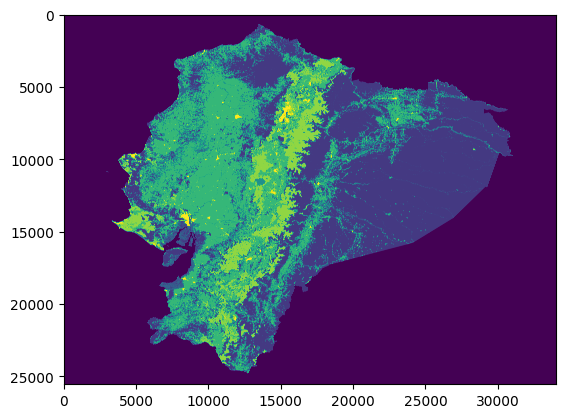

<Axes: >

In [14]:
show(labels_image)

In [15]:
#dataset_rasters =  [rio.open(f'{rasters_path}/{raster}') for raster in os.listdir(rasters_path)]
#print("Numero de Rasters de entrenamiento: ", len(dataset_rasters))

In [16]:
raster_dataser = raster_controller.open_raster(rasters_path)

Number of bands in the image: 8

Image size: 7751 rows x 7601 columns

Raster driver: GTiff

Image projection:
 EPSG:32617



#### Generate balanced training data

In [17]:
pixel_controller = PixelController(label_dataset=dataset_labels)

In [18]:
train_pixels = pixel_controller.generate_training_pixels(image_datasets=[raster_dataser], train_count=500, merge=False)

Train count per dataset:  500
Points per class:  71


Processing << Zona Antropica >>: 100%|██████████| 7/7 [00:56<00:00,  8.13s/it]                 


#### Data Validation
- Balanced and accurate dataset.
- Actual pixel locations.

In [19]:
label_locations = process_data_points(train_pixels=train_pixels, landsat_datasets=[raster_dataser], dataset_labels=dataset_labels)

Processing data point: 496: 100%|██████████| 497/497 [00:05<00:00, 86.03it/s]

('Sin Clasificar', 71)
('Bosque', 70)
('Cuerpo de Agua', 69)
('Otras Tierras', 68)
('Tierra Agropecuaria', 77)
('Vegetacion Arbustiva y Herbacea', 72)
('Zona Antropica', 70)


#### Visualization of Data Locations
Now display the class map along with the locations of training pixels on the image.

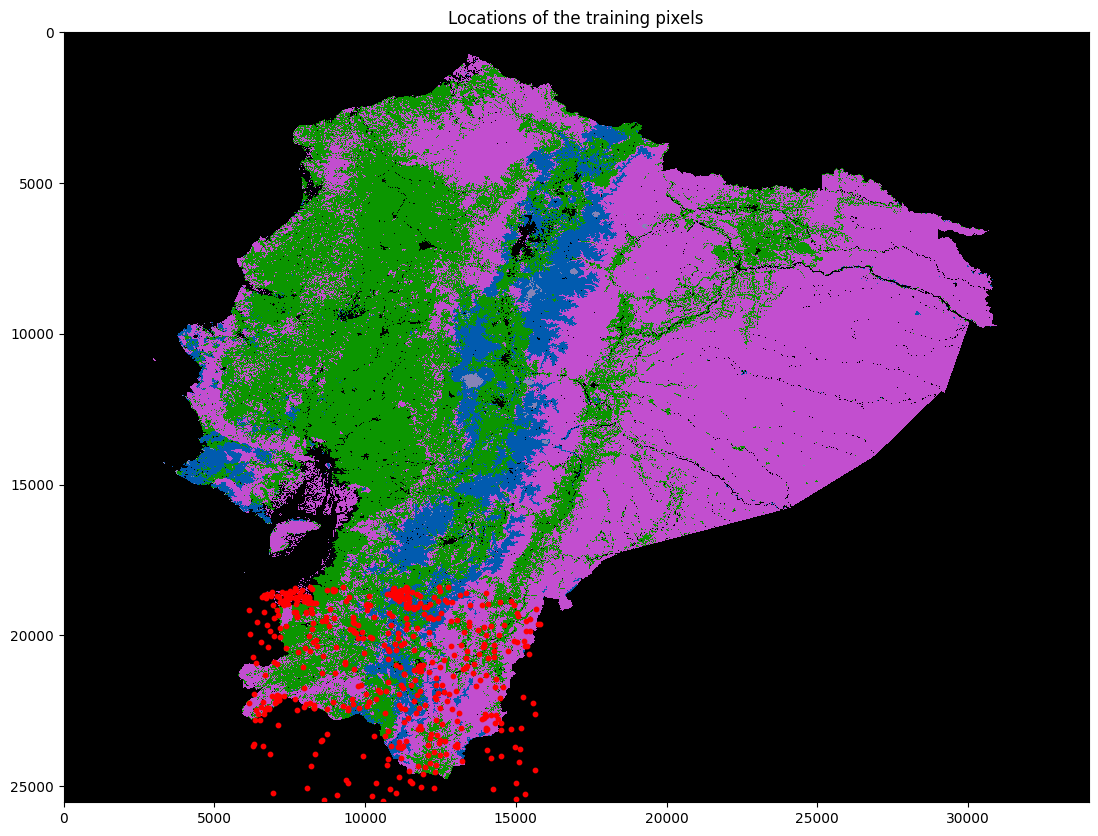

In [20]:
locations_of_pixels(labels_image, label_locations, colors)

#### Testing the Data Generator
Now let's test the data generator to ensure it is working correctly.

In [21]:
l8_proj = Proj(raster_dataser.crs)

In [44]:
%run "/home/theend/Documentos/Develop/Python/Jupyter/soil_desertification/src/controllers/tile.py"

In [45]:
tile_controller = TileController(tile_height=128, tile_width=128, pixel_locations=train_pixels, batch_size=10)

In [46]:
im_batch = None

count = 0
for (im, label) in tile_controller.tile_generators(images_datasets=[raster_dataser], label_dataset=dataset_labels):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----


### Visualización de los mosaicos

Ahora vamos a visualizar los azulejos reales. Tenga en cuenta que se verán poco naturales porque han sido normalizados.

In [47]:
def plot_images_with_labels(image_batch, label_batch, class_names):
    num_images = image_batch.shape[0]
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.62 * 10, 10))

    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols

        axes[row, col].imshow(normalize(image_batch[i, :, :, 3:6]))
        axes[row, col].set_title(class_names[np.argmax(label_batch[i])])

    # Remove any empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)


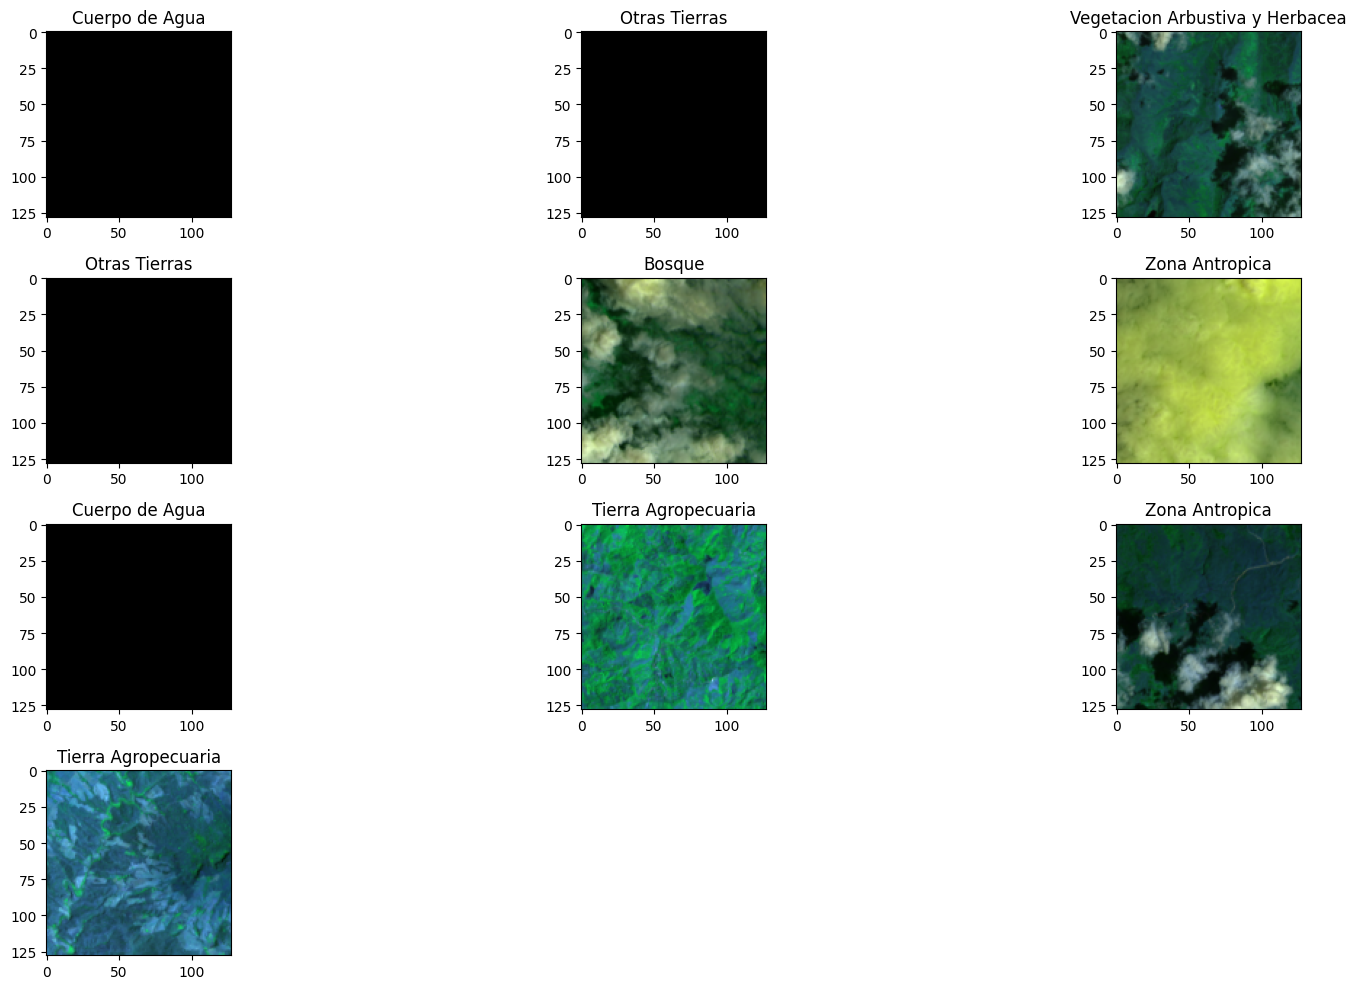

In [48]:
plot_images_with_labels(im_batch, label_batch, LandCoverClassDict().get_landsat_dictionary())

#### Generate 1x1 tile training dataset for scikit-learn for data visualization

In [ ]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in tile_generator(dataset_rasters, dataset_labels, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

#### Resize
Reshape because scikit-learn requires data in the `(samples, features)` format.

In [ ]:
im_batch[0, :, :, :]

In [ ]:
im_batch_reshaped = im_batch.reshape(sample_size, 7)
im_batch_reshaped[0]

#### Visualizing Spectral Signatures

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# numbers 1-8
band_count = np.arange(1, 8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y == class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a titleA
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')

### Building the Actual Neural Network Model

In [ ]:
from tensorflow import keras    
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Dropout
from keras.models import load_model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras.models import Model

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay

#### Setting Hyperparameters

In [ ]:
batch_size = 25
epochs = 25
num_classes = len(class_names)

# dimensiones de la imagen de entrada
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

#### CNN Architecture

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(num_classes))
model.add(Activation('softmax'))

print("\nModel architecture:\n")
model.summary()

In [ ]:
dropout_rate = 0.1
l1 = tf.keras.regularizers.l1(0)

model = Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', activity_regularizer=l1))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activity_regularizer=l1, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(3200, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

print("\nModel architecture:\n")
model.summary()

In [ ]:
from keras.optimizers import Adam
from keras.layers import Bidirectional, LSTM, Dense, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape
from keras.models import Sequential

# Hiperparámetros
learning_rate = 0.001
batch_size = 32
epochs = 50  # Puedes ajustar esto según el rendimiento y el uso de la detección temprana.
dropout_rate = 0.3  # Puedes ajustar esto según el rendimiento.

# Creación del modelo
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_rate))

model.add(Flatten())

# Agregamos una capa de Reshape para convertir la salida en 3D
model.add(Reshape((1, 1024)))

# Agregamos dos capas Bidirectional LSTM
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation='relu')))
model.add(Dropout(dropout_rate))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()


#### Metrics and Model Compilation

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.0003), metrics=['accuracy'])

#### Splitting the Data into Training and Validation

In [ ]:
train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("# Training samples: {n_training} \n# Validation samples: {n_val}".format(n_training=len(train_px), n_val=len(val_px)))

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95):
            print("\n Se ha alcanzado el umbral PRESICION. Entrenamiento detenido.....")
            self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [ ]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='../reports/logs/landsat')

history = model.fit(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size, merge=True
    ),
    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
    validation_data=tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True),
    validation_steps=len(val_px) // batch_size,
    callbacks=[early_stopping, tensorboard]
)

#### Saving the Trained Model

In [ ]:
save_path = '../models/landsat/'
model.save(f"{save_path}model_v1.h5")
print("Saved model to disk")

#### Visualization of Training and Validation Curves

In [ ]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
plt.figure(figsize=(1.62*7, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model error")
plt.ylabel("Error")
plt.xlabel("Epoch")
_ = plt.legend(['Train', 'Test'], loc='upper left')

#### Check Test Accuracy Based on Confusion Matrix

In [ ]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        val_px,
        batch_size,
        merge=True
    ),
    steps=len(val_px) // batch_size,
    verbose=1
)

In [ ]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    val_px,
    batch_size=1,
    merge=True
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Plotting Unnormalized Confusion Matrix

In [ ]:
plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names
)

#### Plotting Normalized Confusion Matrix

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    classes=np.array(list(class_names)),
    class_dict=class_names,
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

### Checking Training Accuracy Based on Confusion Matrix

In [ ]:
predictions = model.predict(
    tile_generator(
        landsat_datasets,
        dataset_labels,
        tile_side,
        tile_side,
        train_px,
        batch_size,
        merge=True
    ),
    steps=len(train_px) // batch_size,
    verbose=1
)

In [ ]:
eval_generator = tile_generator(
    landsat_datasets,
    dataset_labels,
    tile_side,
    tile_side,
    train_px,
    batch_size=1,
    merge=True
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Plotting Unnormalized Confusion Matrix

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Unnormalized'
)

#### Plotting Normalized Confusion Matrix

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Normalized',
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

In [ ]:
print("IPython Notebook execution completed!")

In [ ]:
new_model = tf.keras.models.load_model('../models/landsat/model_v1.h5')

# Check its architecture
new_model.summary()